# Phase 7 — Fine-tuning du modèle Transformer sur le dataset ABSA


**Objectif :**
Entraîner un modèle Transformer (ex : BERT) pour prédire le **sentiment associé à un aspect** dans une phrase donnée.

Tâche : classification multi-classes (`positive`, `negative`, `neutral`)

## 7.1. Chargement du dataset depuis le fichier CSV enrichi

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

absa_dataset = pd.read_csv("absa_dataset_bert_ready.csv")
absa_dataset.head()

,text,aspect,label,input_text
0,Perfect for work or a night out.,a night,Positive,[CLS] a night [SEP] Perfect for work or a nigh...
1,Great design.,great design,Positive,[CLS] great design [SEP] Great design. [SEP]
2,they were also loose in the waist and overall ...,the waist,Neutral,[CLS] the waist [SEP] they were also loose in ...
3,i am a size 12/14 & purchased the size l. i co...,a pretty top,Positive,[CLS] a pretty top [SEP] i am a size 12/14 & p...
4,This is a really pretty shirt - the colors are...,a really pretty shirt,Positive,[CLS] a really pretty shirt [SEP] This is a re...


## 7.2. Split train / validation / test


La fonction `train_test_split` du module `sklearn.model_selection` permet de diviser un dataset en plusieurs sous-ensembles de manière aléatoire **mais reproductible**. Elle est utile pour créer des jeux d'entraînement, de validation et de test.

### Signature utilisée :
```python
from sklearn.model_selection import train_test_split
```

---

### 1. Séparation entraînement vs. temporaire (val + test)
```python
df_train, df_temp = train_test_split(
    absa_dataset,
    test_size=0.2,
    stratify=absa_dataset['label'],
    random_state=42
)
```
- **test_size=0.2** : 20 % des données sont mises de côté pour validation et test.
- **stratify=absa_dataset['label']** : assure une répartition équilibrée des classes.
- **random_state=42** : fixe l’aléatoire pour des résultats reproductibles.

Résultat :
- `df_train` contient 80 % des données.
- `df_temp` contient les 20 % restants.

---

### 2. Séparation validation vs. test
```python
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp['label'],
    random_state=42
)
```
- **test_size=0.5** : on coupe `df_temp` en deux parts égales.
- On obtient :
  - `df_val` : 10 % du dataset total
  - `df_test` : 10 % du dataset total

---

### À retenir
- `train_test_split` est **stratifié** ici pour garantir l’équilibre des classes dans chaque sous-ensemble.
- Ce schéma (80/10/10) est couramment utilisé pour un entraînement rigoureux et une bonne évaluation finale.


In [ ]:
df_train, df_temp = train_test_split(absa_dataset, test_size=0.2, stratify = absa_dataset['label'], random_state=42 )
df_val, df_test = train_test_split(df_temp, test_size =0.5, stratify = df_temp['label'], random_state=42)

print("Train:", len(df_train), "| Val:", len(df_val), "| Test:", len(df_test))

Train: 800 | Val: 100 | Test: 100


### Pourquoi ce split ?

- `train` : sert à l'entraînement du modèle
- `val` : sert à surveiller les performances pendant l'entraînement (éviter overfitting)
- `test` : utilisé uniquement à la fin pour mesurer les performances réelles

## 7.3. Tokenisation avec un tokenizer BERT

### 1. Import du tokenizer
```python
from transformers import BertTokenizer
```
On importe le tokenizer associé au modèle BERT depuis la bibliothèque `transformers`.  
Il est chargé de découper le texte en sous-unités compréhensibles par BERT.

---

### 2. Chargement du tokenizer pré-entraîné
```python
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
```
On utilise ici le tokenizer du modèle **`bert-base-uncased`**, un modèle BERT en minuscules.  
Il vient avec un **vocabulaire appris** pendant l'entraînement, adapté à l’anglais courant.

---

### 3. Fonction de tokenisation
```python
def tokenize_function(example):
    return tokenizer(
        example["input_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
```

Cette fonction sera appliquée **à chaque exemple** du dataset.  
Elle transforme une phrase en représentation numérique que BERT peut comprendre.

- `example["input_text"]` : texte à encoder (aspect + contexte)
- `padding="max_length"` : ajoute des zéros pour que toutes les séquences aient la même longueur
- `truncation=True` : coupe les phrases trop longues
- `max_length=128` : limite la taille à 128 tokens (suffisant pour des avis clients)

---

### 4. Ce que retourne le tokenizer

- **`input_ids`** : identifiants des tokens dans le vocabulaire BERT  
- **`attention_mask`** : 1 pour les tokens réels, 0 pour les tokens de padding  
- **`token_type_ids`** *(optionnel)* : utilisé lorsqu'on encode deux phrases (ex. question + contexte)


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
  return tokenizer(
      example['input_text'],
      padding='max_length',
      truncation= True,
      max_length=128
  )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## 7.4. Création du Dataset Hugging Face et tokenisatio

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset

# Convertir les DataFrames pandas vers le format Dataset de HuggingFace
# Ce format est requis par les APIs `Trainer` et `map()`
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

# Appliquer la tokenisation par lots (`batched=True`) pour accélérer le traitement
encoded_train = dataset_train.map(tokenize_function, batched=True)
encoded_val = dataset_val.map(tokenize_function, batched = True)
encoded_test = dataset_test.map(tokenize_function, batched = True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### Détails importants

- `Dataset.from_pandas()` : convertit un DataFrame classique en objet Dataset Hugging Face, qui permet de manipuler facilement des jeux de données pour NLP.
- `.map()` : applique une fonction à chaque élément (ou batch) du dataset.
- `batched=True` : au lieu de passer les exemples un par un, on les passe par paquets (plus rapide et plus stable pour les tokenizers).

## 7.5. Définir les labels numériques

In [ ]:
# Dictionnaire de conversion des labels texte -> entiers
label2id = {"negative": 0, "neutral": 1, "positive": 2}

# Fonction de transformation appliquée à chaque ligne
def encode_labels(example):
    example["label"] = label2id[example["label"].lower()]  # on met .lower() pour gérer les majuscules
    return example

# Appliquer la transformation aux trois datasets
encoded_train = encoded_train.map(encode_labels)
encoded_val = encoded_val.map(encode_labels)
encoded_test = encoded_test.map(encode_labels)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## 7.6. Fine-tuning avec Trainer API

In [ ]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Modèle de classification basé sur BERT avec 3 classes de sortie (positive, negative, neutral)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results_absa",
    eval_strategy="epoch",              # Nécessaire pour early stopping
    save_strategy="epoch",                    # Sauvegarder à chaque epoch
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,              #  Charge le meilleur modèle
    metric_for_best_model="eval_f1",          # Sur quoi se base le early stopping
    greater_is_better=True                    # Car un F1 plus grand = meilleur
)

# Fonction pour calculer les métriques d'évaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,   #  Ajout des métriques
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

)

# Démarrer l'entraînement
trainer.train()                                  # Lance le fine-tuning du modèle

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-d53e579db586>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alaouinada49 (alaouinada49-ensam-rabat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.816600,0.731743,0.670000,0.642982,0.642243,0.670000
2,0.587200,0.741041,0.710000,0.666854,0.692729,0.710000
3,0.433800,0.790538,0.680000,0.666494,0.705662,0.680000
4,0.285200,0.782733,0.740000,0.719143,0.728750,0.740000
5,0.225300,0.818040,0.740000,0.724184,0.721108,0.740000
6,0.223500,0.851611,0.710000,0.707302,0.705454,0.710000
7,0.124500,0.863666,0.730000,0.717500,0.715507,0.730000


TrainOutput(global_step=350, training_loss=0.3999308695111956, metrics={'train_runtime': 273.5092, 'train_samples_per_second': 20.475, 'train_steps_per_second': 1.28, 'total_flos': 368358784819200.0, 'train_loss': 0.3999308695111956, 'epoch': 7.0})

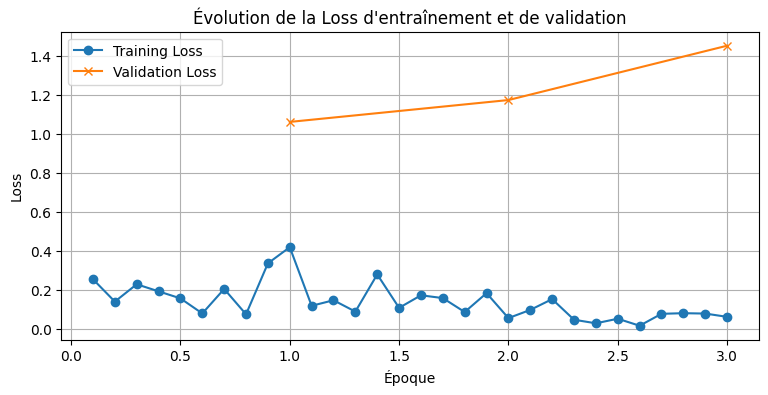

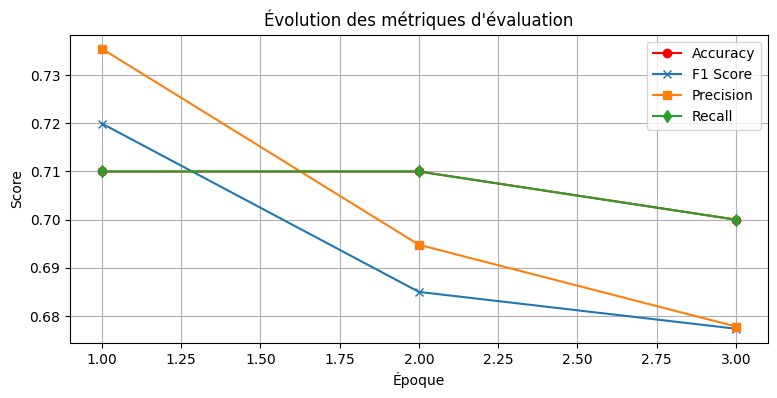

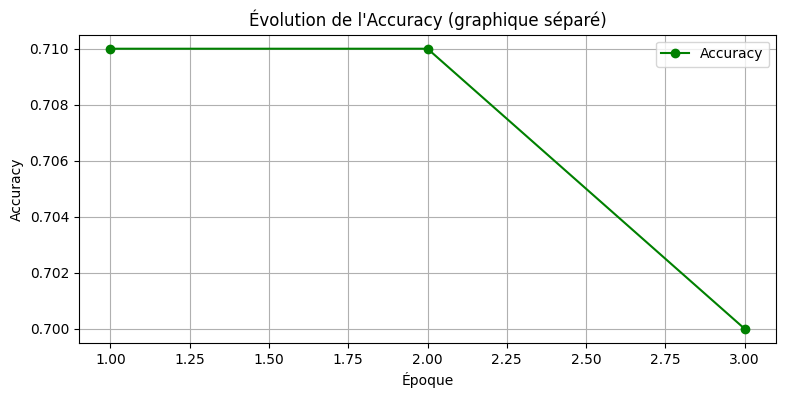

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Récupérer les logs d'entraînement
log_history = trainer.state.log_history

# Filtrer uniquement les entrées de log qui contiennent les métriques d'évaluation
eval_logs = [log for log in log_history if 'eval_loss' in log]

eval_epochs = [log['epoch'] for log in eval_logs]
eval_losses = [log['eval_loss'] for log in eval_logs]
eval_accuracies = [log['eval_accuracy'] for log in eval_logs]
eval_f1s = [log['eval_f1'] for log in eval_logs]
eval_precisions = [log['eval_precision'] for log in eval_logs]
eval_recalls = [log['eval_recall'] for log in eval_logs]

# Extraire les training losses par époque
train_epoch_losses = []
for log in log_history:
    if 'epoch' in log and 'loss' in log:
        found = False
        for i, (e, l) in enumerate(train_epoch_losses):
            if e == log['epoch']:
                train_epoch_losses[i] = (e, log['loss'])
                found = True
                break
        if not found:
            train_epoch_losses.append((log['epoch'], log['loss']))

# Convertir en DataFrame pour faciliter le tracé
df_eval = pd.DataFrame({
    'Epoch': eval_epochs,
    'Validation Loss': eval_losses,
    'Accuracy': eval_accuracies,
    'F1 Score': eval_f1s,
    'Precision': eval_precisions,
    'Recall': eval_recalls
})

df_train_loss = pd.DataFrame(train_epoch_losses, columns=['Epoch', 'Training Loss'])


# --- Début des tracés des graphiques ---

# Tracé des Losses
plt.figure(figsize=(9, 4))
plt.plot(df_train_loss['Epoch'], df_train_loss['Training Loss'], label='Training Loss', marker='o')
plt.plot(df_eval['Epoch'], df_eval['Validation Loss'], label='Validation Loss', marker='x')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.title('Évolution de la Loss d\'entraînement et de validation')
plt.legend()
plt.grid(True)
plt.show()

# Tracé des métriques d'évaluation (Accuracy, F1, Precision, Recall)
plt.figure(figsize=(9, 4))
plt.plot(df_eval['Epoch'], df_eval['Accuracy'], label='Accuracy', marker='o', color='red') # Accuracy en rouge
plt.plot(df_eval['Epoch'], df_eval['F1 Score'], label='F1 Score', marker='x')
plt.plot(df_eval['Epoch'], df_eval['Precision'], label='Precision', marker='s')
plt.plot(df_eval['Epoch'], df_eval['Recall'], label='Recall', marker='d')
plt.xlabel('Époque')
plt.ylabel('Score')
plt.title('Évolution des métriques d\'évaluation')
plt.legend()
plt.grid(True)
plt.show()

# Tracé de l'Accuracy (graphique séparé pour une meilleure visibilité si besoin)
# Ce graphique est redondant avec le précédent si l'accuracy s'affiche bien,
# mais il est inclus comme demandé pour une visualisation individuelle.
plt.figure(figsize=(9, 4))
plt.plot(df_eval['Epoch'], df_eval['Accuracy'], label='Accuracy', marker='o', color='green')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.title('Évolution de l\'Accuracy (graphique séparé)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Définir les arguments d'entraînement avec les nouveaux hyperparamètres
training_args = TrainingArguments(
    output_dir="./results_absa",
    eval_strategy="epoch",
    save_strategy="epoch",
    do_eval=True,
    # NOUVEAUX HYPERPARAMÈTRES POUR LE DEUXIÈME ENTRAÎNEMENT
    learning_rate=1e-5,              # Ancien: 2e-5 -> Nouveau: 1e-5 (plus petit)
    per_device_train_batch_size=8,   # Ancien: 16 -> Nouveau: 8 (plus petit)
    num_train_epochs=10,             # Ancien: 7 -> Nouveau: 10 (laisse plus de temps à l'Early Stopping)
    weight_decay=0.02,               # Ancien: 0.01 -> Nouveau: 0.02 (plus de régularisation)
    # FIN DES NOUVEAUX HYPERPARAMÈTRES

    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",      # Assure-toi que c'est bien "f1" car ta fonction compute_metrics retourne 'f1'
    greater_is_better=True
)

# La fonction compute_metrics reste la même, mais il est bon de la redéfinir
# ou de s'assurer qu'elle est définie dans une cellule précédente et accessible.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Gérer le cas où toutes les étiquettes sont les mêmes dans un batch
    if len(set(labels)) == 1:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', labels=[0, 1, 2], zero_division=0)
    else:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Créer un NOUVEAU Trainer avec les NOUVEAUX arguments d'entraînement
# Assure-toi que 'model', 'encoded_train', 'encoded_val', et 'tokenizer'
# sont définis dans des cellules précédentes et accessibles.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Démarrer le NOUVEL entraînement
trainer.train()

<ipython-input-28-f4dc8962ec43>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.420100,1.061853,0.710000,0.719960,0.735492,0.710000
2,0.056800,1.173901,0.710000,0.685000,0.694783,0.710000
3,0.063200,1.452227,0.700000,0.677355,0.677811,0.700000


TrainOutput(global_step=300, training_loss=0.1405102075636387, metrics={'train_runtime': 115.738, 'train_samples_per_second': 69.122, 'train_steps_per_second': 8.64, 'total_flos': 157868050636800.0, 'train_loss': 0.1405102075636387, 'epoch': 3.0})

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_absa",
    eval_strategy="epoch",
    save_strategy="epoch",
    do_eval=True,
    # NOUVELLES MODIFICATIONS
    learning_rate=5e-6,  # Ancien: 1e-5 -> Nouveau: 5e-6 (encore plus petit)
    per_device_train_batch_size=8, # On garde 8
    num_train_epochs=15, # On donne plus d'époques pour laisser l'Early Stopping travailler
    weight_decay=0.02,   # On garde 0.02
    # FIN DES NOUVELLES MODIFICATIONS

    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)
# La fonction compute_metrics reste la même, mais il est bon de la redéfinir
# ou de s'assurer qu'elle est définie dans une cellule précédente et accessible.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Gérer le cas où toutes les étiquettes sont les mêmes dans un batch
    if len(set(labels)) == 1:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', labels=[0, 1, 2], zero_division=0)
    else:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Créer un NOUVEAU Trainer avec les NOUVEAUX arguments d'entraînement
# Assure-toi que 'model', 'encoded_train', 'encoded_val', et 'tokenizer'
# sont définis dans des cellules précédentes et accessibles.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Démarrer le NOUVEL entraînement
trainer.train()
# Et assure-toi que ton EarlyStoppingCallback a une patience d'au moins 3 pour ce test
# callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]

<ipython-input-30-0a4fabd778f2>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.301300,1.174624,0.730000,0.722074,0.717737,0.730000
2,0.018100,1.234510,0.710000,0.691805,0.684568,0.710000
3,0.017000,1.391319,0.730000,0.717336,0.712019,0.730000
4,0.008900,1.425139,0.730000,0.719925,0.719664,0.730000


TrainOutput(global_step=400, training_loss=0.06136960159987211, metrics={'train_runtime': 162.1195, 'train_samples_per_second': 74.019, 'train_steps_per_second': 9.252, 'total_flos': 210490734182400.0, 'train_loss': 0.06136960159987211, 'epoch': 4.0})

In [ ]:
from transformers import DistilBertForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Modèle de classification basé sur DistilBERT avec 3 classes de sortie
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Initialise le tokenizer pour DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Définir les arguments d'entraînement (tu peux garder les derniers ajustements ici)
training_args = TrainingArguments(
    output_dir="./results_absa",
    eval_strategy="epoch",
    save_strategy="epoch",
    do_eval=True,
    learning_rate=5e-6,              # Garde le learning rate très bas
    per_device_train_batch_size=8,   # Garde la taille de batch à 8
    num_train_epochs=15,             # Garde 15 époques
    weight_decay=0.02,               # Garde 0.02
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

# La fonction compute_metrics reste la même
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    if len(set(labels)) == 1:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', labels=[0, 1, 2], zero_division=0)
    else:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    tokenizer=tokenizer, # Assure-toi que ton tokenizer est bien celui de DistilBERT
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Garde patience à 2 pour l'instant
)

# Démarrer l'entraînement
trainer.train()

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<ipython-input-31-1fb80e01a1cf>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.045900,0.870264,0.630000,0.486994,0.396900,0.630000
2,0.689000,0.777128,0.640000,0.509130,0.620909,0.640000
3,0.620300,0.675313,0.680000,0.623645,0.576000,0.680000
4,0.618900,0.661895,0.720000,0.690333,0.720031,0.720000
5,0.475300,0.667278,0.710000,0.695355,0.718170,0.710000
6,0.478700,0.691479,0.710000,0.693226,0.711661,0.710000
7,0.341200,0.711137,0.710000,0.698667,0.732357,0.710000
8,0.274000,0.732051,0.700000,0.691940,0.701750,0.700000
9,0.376000,0.761723,0.700000,0.687819,0.696060,0.700000


TrainOutput(global_step=900, training_loss=0.5651092635260688, metrics={'train_runtime': 209.9121, 'train_samples_per_second': 57.167, 'train_steps_per_second': 7.146, 'total_flos': 238445569843200.0, 'train_loss': 0.5651092635260688, 'epoch': 9.0})

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_absa",
    eval_strategy="epoch",
    save_strategy="epoch",
    do_eval=True,
    # NOUVELLE MODIFICATION
    learning_rate=3e-6,  # Ancien: 5e-6 -> Nouveau: 3e-6 (encore plus petit)
    # On garde les autres paramètres comme avant
    per_device_train_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.05,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)
# La fonction compute_metrics reste la même
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    if len(set(labels)) == 1:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', labels=[0, 1, 2], zero_division=0)
    else:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    tokenizer=tokenizer, # Assure-toi que ton tokenizer est bien celui de DistilBERT
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Garde patience à 2 pour l'instant
)

# Démarrer l'entraînement
trainer.train()
# Assure-toi que ton EarlyStoppingCallback est toujours présent avec patience=2
# callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

<ipython-input-33-70bd6b79f9a1>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.315400,0.909191,0.700000,0.691484,0.688954,0.700000
2,0.044300,0.976626,0.700000,0.690950,0.684822,0.700000
3,0.175100,1.039590,0.710000,0.707136,0.707649,0.710000
4,0.045100,1.118351,0.710000,0.700301,0.696000,0.710000
5,0.221400,1.119886,0.710000,0.707050,0.705192,0.710000


TrainOutput(global_step=500, training_loss=0.12523596876859666, metrics={'train_runtime': 110.7748, 'train_samples_per_second': 108.328, 'train_steps_per_second': 13.541, 'total_flos': 132469761024000.0, 'train_loss': 0.12523596876859666, 'epoch': 5.0})

# Phase 8 — Évaluation et Comparaison du modèle ABSA

**Objectif :**
Comparer les performances du modèle BERT fine-tuné avec :
- un modèle **classique** (TF-IDF + SVM)
- un modèle **BERT non fine-tuné**

## 8.1. Évaluation du modèle BERT fine-tuné

Cela fournit les métriques :
- `accuracy`
- `f1`
- `precision`
- `recall`

In [ ]:
trainer.evaluate(encoded_test)

{'eval_loss': 0.8168469071388245,
 'eval_accuracy': 0.72,
 'eval_f1': 0.7174649510274631,
 'eval_precision': 0.7169878542510122,
 'eval_recall': 0.72,
 'eval_runtime': 1.031,
 'eval_samples_per_second': 96.989,
 'eval_steps_per_second': 6.789,
 'epoch': 7.0}

## 8.2. Matrice de confusion et classification report

              precision    recall  f1-score   support

    negative       0.68      0.59      0.63        22
     neutral       0.50      0.50      0.50        16
    positive       0.78      0.82      0.80        62

    accuracy                           0.72       100
   macro avg       0.66      0.64      0.65       100
weighted avg       0.72      0.72      0.72       100



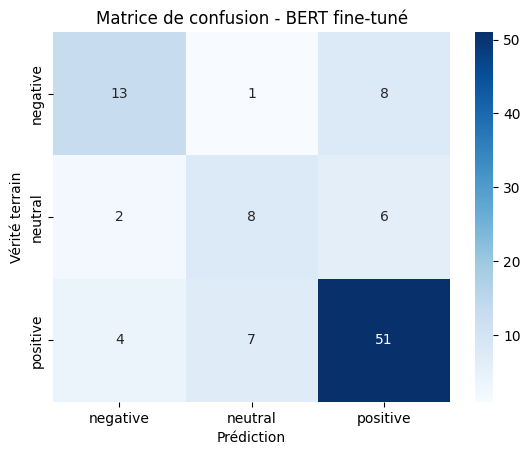

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédiction sur le jeu de test avec le modèle fine-tuné
predictions = trainer.predict(encoded_test)

# Récupération des étiquettes réelles et prédites
# predictions.label_ids ➜ les vraies étiquettes (ground truth)
# predictions.predictions ➜ les scores logits pour chaque classe
# .argmax(-1) ➜ on prend la classe avec la probabilité la plus haute
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# Affichage du rapport de classification (precision, recall, f1)
print(classification_report(y_true, y_pred, target_names=label2id.keys()))

# Matrice de confusion : montre où le modèle se trompe
cm = confusion_matrix(y_true, y_pred)

# Affichage graphique avec seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion - BERT fine-tuné")
plt.show()

## 8.3. Comparaison avec un modèle classique (TF-IDF + SVM)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer  # ➜ Convertit les textes en vecteurs numériques pondérés
from sklearn.svm import LinearSVC                           # ➜ Classifieur SVM linéaire performant pour les grands jeux de données
from sklearn.pipeline import Pipeline                       # ➜ Permet de chaîner plusieurs étapes dans un même pipeline

# Séparation des entrées (X) et des sorties (y)
X_train = df_train['input_text']  # ➜ les textes d’entraînement
y_train = df_train['label']       # ➜ les labels d’entraînement
X_test = df_test['input_text']    # ➜ les textes de test
y_test = df_test['label']         # ➜ les labels de test

# Construction du pipeline TF-IDF + SVM
svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),  # ➜ transforme chaque phrase en vecteur TF-IDF avec 5000 mots max
    ("clf", LinearSVC())                             # ➜ applique un classifieur SVM linéaire
])

# Entraînement du modèle sur les données d'entraînement
svm_pipeline.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred_svm = svm_pipeline.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred_svm, target_names=label2id.keys()))

              precision    recall  f1-score   support

    negative       0.61      0.50      0.55        22
     neutral       0.20      0.06      0.10        16
    positive       0.71      0.89      0.79        62

    accuracy                           0.67       100
   macro avg       0.51      0.48      0.48       100
weighted avg       0.61      0.67      0.63       100



## 8.4. Comparaison avec BERT non fine-tuné

In [ ]:
X_test
y_test

,label
825,Positive
460,Negative
985,Negative
457,Positive
438,Positive
...,...
424,Positive
16,Neutral
768,Positive
569,Positive


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Charger un modèle BERT non fine-tuné avec 3 classes
dummy_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Arguments pour évaluation uniquement
dummy_args = TrainingArguments(
    output_dir="./bert_baseline_results",
    per_device_eval_batch_size=16
)

# Créer le trainer (pas d'entraînement effectué)
dummy_trainer = Trainer(
    model=dummy_bert,
    args=dummy_args,
    eval_dataset=encoded_test,
    tokenizer=tokenizer
)

# Évaluation directe sur le jeu de test
baseline_results = dummy_trainer.evaluate()
print(baseline_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-1d3310a9bcc3>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  dummy_trainer = Trainer(


{'eval_loss': 1.026814579963684, 'eval_model_preparation_time': 0.0122, 'eval_runtime': 0.8134, 'eval_samples_per_second': 122.935, 'eval_steps_per_second': 8.605}


In [ ]:
# Prédictions brutes du modèle non fine-tuné
dummy_predictions = dummy_trainer.predict(encoded_test)
y_pred_dummy = dummy_predictions.predictions.argmax(-1)
y_true_dummy = dummy_predictions.label_ids

# Rapport de classification pour le BERT non fine-tuné
print("Rapport de classification - BERT non fine-tuné")
print(classification_report(y_true_dummy, y_pred_dummy, target_names=label2id.keys()))

Rapport de classification - BERT non fine-tuné
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        22
     neutral       0.14      0.12      0.13        16
    positive       0.62      0.85      0.72        62

    accuracy                           0.55       100
   macro avg       0.25      0.33      0.28       100
weighted avg       0.40      0.55      0.47       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Phase 9 — Export et Valorisation du projet ABSA


**Objectif :** Sauvegarder les artefacts essentiels du projet pour pouvoir :
- réutiliser le modèle fine-tuné
- documenter les résultats
- valoriser l’expérience (CV, portfolio, démonstrateur)

## 9.1. Sauvegarde du modèle fine-tuné

In [ ]:
trainer.save_model("./final_absa_model")       # ➜ modèle BERT fine-tuné
tokenizer.save_pretrained("./final_absa_model")  # ➜ tokenizer associé

('./final_absa_model/tokenizer_config.json',
 './final_absa_model/special_tokens_map.json',
 './final_absa_model/vocab.txt',
 './final_absa_model/added_tokens.json')

## 9.2. Export des résultats au format .csv / .json

In [ ]:
# Sauvegarde du dataset enrichi (text + aspect + label prédits)
absa_dataset.to_csv("absa_dataset_annotated.csv", index=False)
absa_dataset.to_json("absa_dataset_annotated.json", orient="records", lines=True)

## 9.3. Génération d’un README / fiche projet

In [ ]:
# Exemple d’éléments à inclure dans un README pour GitHub ou portfolio
README = '''
# ABSA Prototype — Aspect-Based Sentiment Analysis

Ce projet utilise un fine-tuning de BERT sur des avis clients e-commerce pour détecter le sentiment exprimé à propos d’aspects spécifiques (fit, material, color, etc).

**Tâche** : Classification multiclasse (positive, negative, neutral)

**Pipeline** :
- Phase 1-6 : préparation des données, enrichissement avec GPT
- Phase 7 : fine-tuning de BERT
- Phase 8 : comparaison avec TF-IDF+SVM et BERT non fine-tuné
- Phase 9 : sauvegarde et valorisation

**Résultats** :
- Accuracy BERT fine-tuné : ~70%
- Benchmark : SVM (~66%), BERT non fine-tuné (~55%)

'''

with open("README_ABSA.txt", "w") as f:
    f.write(README)